In [1]:
print("Welcome to Yard!")

Welcome to Yard!


In [2]:
%load_ext autoreload
%autoreload 2
%load_ext dotenv
%dotenv

import json
import logging
import sys
from pathlib import Path

import ipytest

CODE_FOLDER = Path("code")
sys.path.extend([f"./{CODE_FOLDER}"])

DATA_FILEPATH = "../data/penguins.csv"

ipytest.autoconfig(raise_on_error=True)

# By default, The SageMaker SDK logs events related to the default
# configuration using the INFO level. To prevent these from spoiling
# the output of this notebook cells, we can change the logging
# level to ERROR instead.
logging.getLogger("sagemaker.config").setLevel(logging.ERROR)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [2]:
LOCAL_MODE = True

In [4]:
import os

bucket = os.environ["BUCKET"]
role = os.environ["ROLE"]

COMET_API_KEY = os.environ.get("COMET_API_KEY", None)
COMET_PROJECT_NAME = os.environ.get("COMET_PROJECT_NAME", None)

In [6]:
# We can retrieve the architecture of the local
# computer using the `uname -m` command.
architecture = !(uname -m)

IS_ARM64_ARCHITECTURE = architecture[0] == "arm64"
print(IS_ARM64_ARCHITECTURE)

False


In [7]:
import sagemaker
from sagemaker.workflow.pipeline_context import LocalPipelineSession, PipelineSession

pipeline_session = PipelineSession(default_bucket=bucket) if not LOCAL_MODE else None

if LOCAL_MODE:
    config = {
        "session": LocalPipelineSession(default_bucket=bucket),
        "instance_type": "local",
        # We need to use a custom Docker image when we run the pipeline
        # in Local Model on an ARM64 machine.
        "image": (
            "sagemaker-tensorflow-toolkit-local" if IS_ARM64_ARCHITECTURE else None
        ),
    }
else:
    config = {
        "session": pipeline_session,
        "instance_type": "ml.m5.xlarge",
        "image": None,
    }

# These specific settings refer to the SageMaker
# TensorFlow container we'll use.
config["framework_version"] = "2.12"
config["py_version"] = "py310"

sagemaker.config INFO - Not applying SDK defaults from location: C:\ProgramData\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\Users\hemch\AppData\Local\sagemaker\sagemaker\config.yaml


Windows Support for Local Mode is Experimental


In [8]:
import boto3

S3_LOCATION = f"s3://{bucket}/penguins"

sagemaker_session = sagemaker.session.Session()
sagemaker_client = boto3.client("sagemaker")
iam_client = boto3.client("iam")
region = boto3.Session().region_name

print(region)

us-east-1


### Analysing penguins

In [3]:
import pandas as pd
import numpy as np

penguins = pd.read_csv(DATA_FILEPATH)
penguins.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [4]:
penguins.describe(include="all")

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
count,344,344,342.000000,342.000000,342.000000,342.000000,334
unique,3,3,NaN,NaN,NaN,NaN,3
top,Adelie,Biscoe,NaN,NaN,NaN,NaN,MALE
freq,152,168,NaN,NaN,NaN,NaN,168
mean,NaN,NaN,43.921930,17.151170,200.915205,4201.754386,NaN
std,NaN,NaN,5.459584,1.974793,14.061714,801.954536,NaN
min,NaN,NaN,32.100000,13.100000,172.000000,2700.000000,NaN
25%,NaN,NaN,39.225000,15.600000,190.000000,3550.000000,NaN
50%,NaN,NaN,44.450000,17.300000,197.000000,4050.000000,NaN
75%,NaN,NaN,48.500000,18.700000,213.000000,4750.000000,NaN


In [13]:
def print_categorical_distribution(_penguins):
    species_dist = _penguins.species.value_counts()
    island_dist = _penguins.island.value_counts()
    sex_dist = _penguins.sex.value_counts()

    print(species_dist)
    print(island_dist)
    print(sex_dist)

print_categorical_distribution(penguins)

species
Adelie       152
Gentoo       124
Chinstrap     68
Name: count, dtype: int64
island
Biscoe       168
Dream        124
Torgersen     52
Name: count, dtype: int64
sex
MALE      179
FEMALE    165
Name: count, dtype: int64


In [6]:
penguins['sex'] = penguins['sex'].replace('.',np.nan)

In [8]:
print(penguins[['sex']].value_counts())

sex   
MALE      168
FEMALE    165
Name: count, dtype: int64


In [9]:
penguins.isnull().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

### Inpute missing values

In [10]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="most_frequent")
penguins.iloc[:,:]  = imputer.fit_transform(penguins)

In [11]:
penguins.isnull().sum()

species              0
island               0
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

In [12]:
penguins.shape

(344, 7)

In [14]:
print_categorical_distribution(penguins)

species
Adelie       152
Gentoo       124
Chinstrap     68
Name: count, dtype: int64
island
Biscoe       168
Dream        124
Torgersen     52
Name: count, dtype: int64
sex
MALE      179
FEMALE    165
Name: count, dtype: int64


### Visualization

In [20]:
import matplotlib.pyplot as plt

def plot_categorocal_distribution(_df):

    categorical_columns = ['species', 'island', 'sex']

    # Create subplots
    fig, axes = plt.subplots(nrows=len(categorical_columns), ncols=1, figsize=(8, 15))

    # Plot each categorical column
    for i, column in enumerate(categorical_columns):
        # Count the frequency of each category
        counts = _df[column].value_counts()
        
        # Plot the bar plot
        counts.plot(kind='bar', ax=axes[i])
        
        # Set the title and labels
        axes[i].set_title(f'distribution of {column}')
        axes[i].set_xlabel('Frequency')
        axes[i].set_ylabel(column)

    # Adjust layout
    plt.tight_layout()
    plt.show()

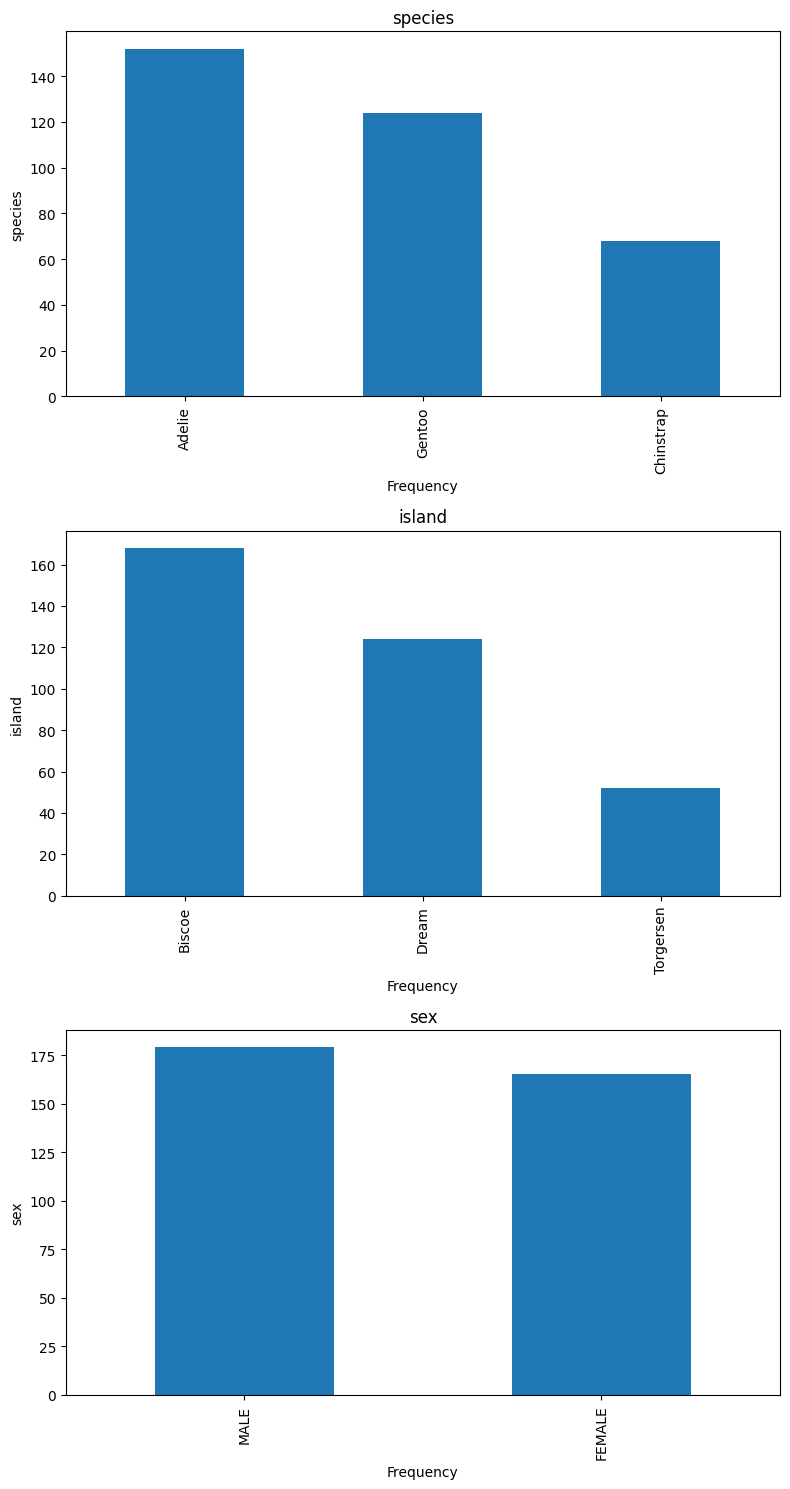

In [21]:
plot_categorocal_distribution(penguins)

In [28]:
def plot_distributions(df):
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Assuming your DataFrame is named df
    categorical_columns = ['species', 'island', 'sex']
    numerical_columns = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']

    # Set style
    sns.set_style("whitegrid")

    # Create subplots
    fig, axes = plt.subplots(nrows=len(categorical_columns) + len(numerical_columns), ncols=1, figsize=(8, 20))

    # Plot categorical columns
    for i, column in enumerate(categorical_columns):
        # Count the frequency of each category
        counts = df[column].value_counts()
        
        # Plot the bar plot
        sns.barplot(x=counts.index, y=counts.values, ax=axes[i])
        
        # Set the title and labels
        axes[i].set_title(f'distribution of {column}')
        axes[i].set_xlabel('Frequency')
        axes[i].set_ylabel(column)

    # Plot numerical columns
    for i, column in enumerate(numerical_columns, start=len(categorical_columns)):
        # Plot histogram
        sns.histplot(df[column], kde=True, ax=axes[i])
        
        # Set the title and labels
        axes[i].set_title(f'distribution of {column}')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Frequency')

    # Adjust layout
    plt.tight_layout()
    plt.show()
    


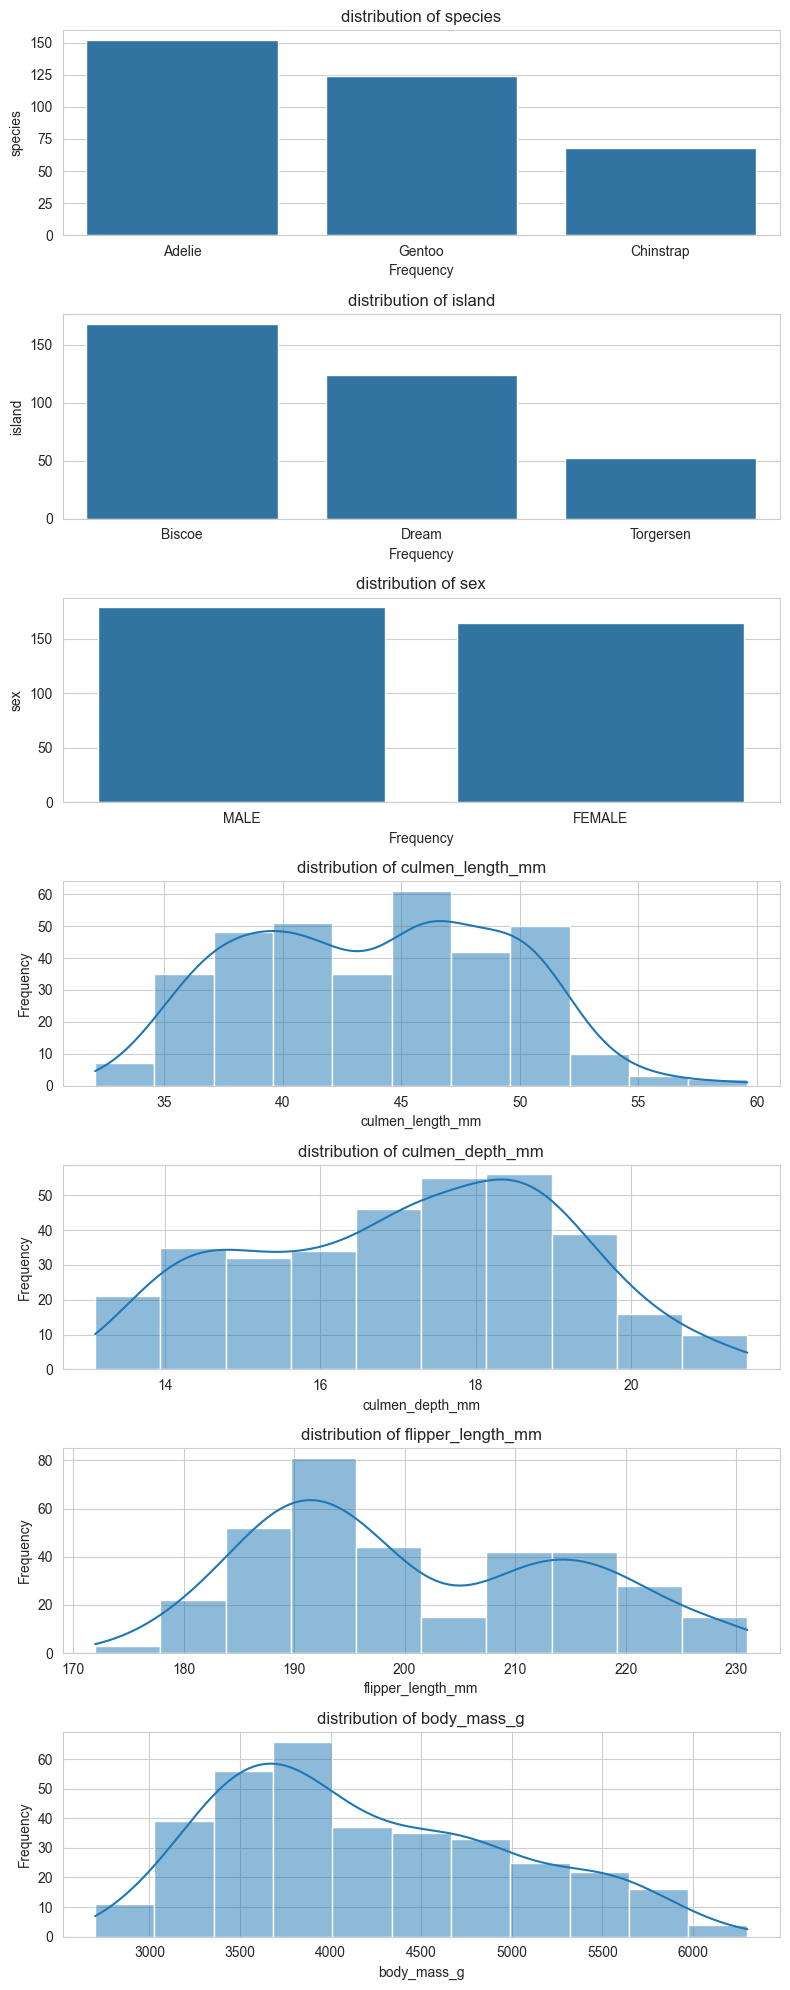

In [29]:
plot_distributions(penguins)

## Covarience

In [31]:
penguins.cov(numeric_only=True)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
culmen_length_mm,29.679415,-2.516984,50.260588,2596.971151
culmen_depth_mm,-2.516984,3.877201,-16.108849,-742.660180
flipper_length_mm,50.260588,-16.108849,197.269501,9792.552037
body_mass_g,2596.971151,-742.660180,9792.552037,640316.716388


## Correlation

In [32]:
penguins.corr(numeric_only=True)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
culmen_length_mm,1.000000,-0.234635,0.656856,0.595720
culmen_depth_mm,-0.234635,1.000000,-0.582472,-0.471339
flipper_length_mm,0.656856,-0.582472,1.000000,0.871302
body_mass_g,0.595720,-0.471339,0.871302,1.000000


In [43]:
import seaborn as sns

def plot_species_distribution_by_island(dataframe):
    # Set style
    sns.set_style("whitegrid")

    # Create count plot with overlapping bars
    plt.figure(figsize=(10, 6))
    sns.countplot(data=dataframe, x='island', hue='species')
    plt.title('Distribution of Species by Island')
    plt.xlabel('Island')
    plt.ylabel('Count')
    plt.legend(title='Species')
    plt.show()

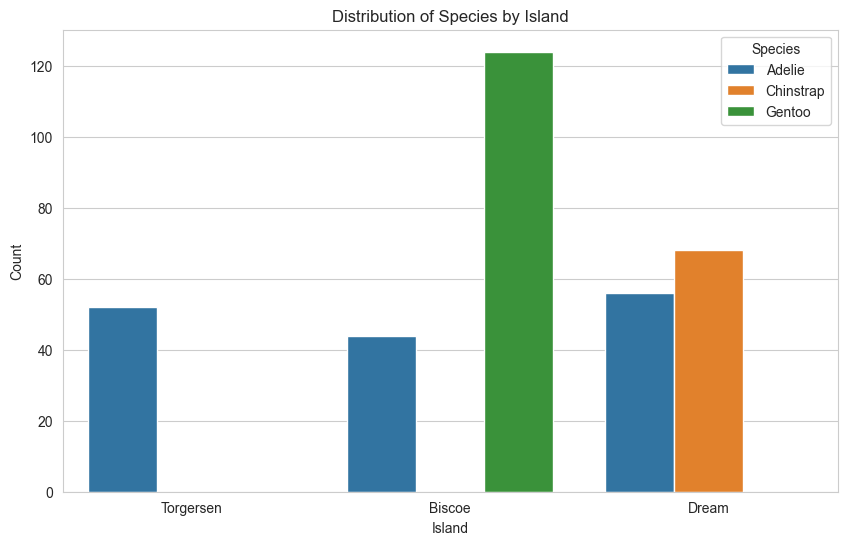

In [44]:
plot_species_distribution_by_island(penguins)

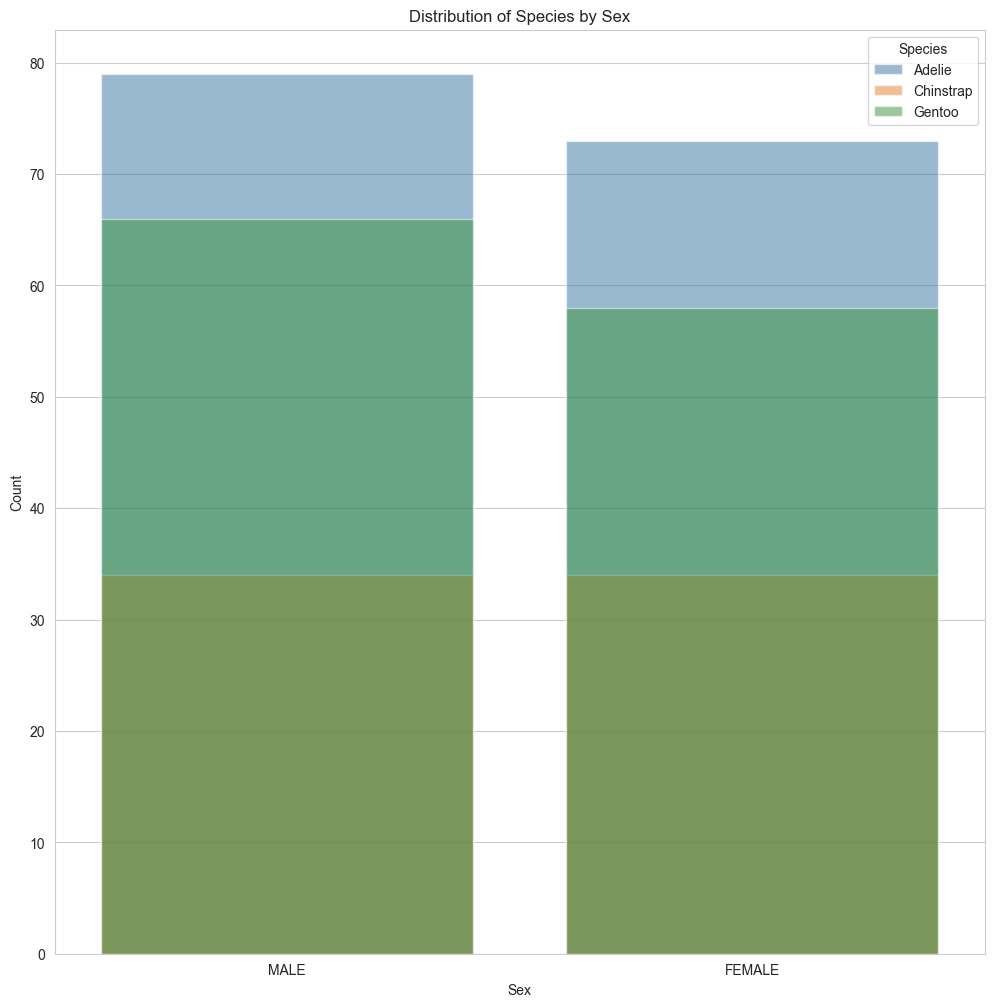

In [48]:
def plot_species_distribution(dataframe, category_column, transparency=0.7):
    # Set style
    sns.set_style("whitegrid")

    # Create count plot with overlapping and transparent bars
    plt.figure(figsize=(12, 12))
    sns.countplot(data=dataframe, x=category_column, hue='species', dodge=False, alpha=transparency)
    plt.title('Distribution of Species by ' + category_column.capitalize())
    plt.xlabel(category_column.capitalize())
    plt.ylabel('Count')
    plt.legend(title='Species')
    plt.show()

# Sample usage with your DataFrame
plot_species_distribution(penguins, 'sex', transparency=0.5)

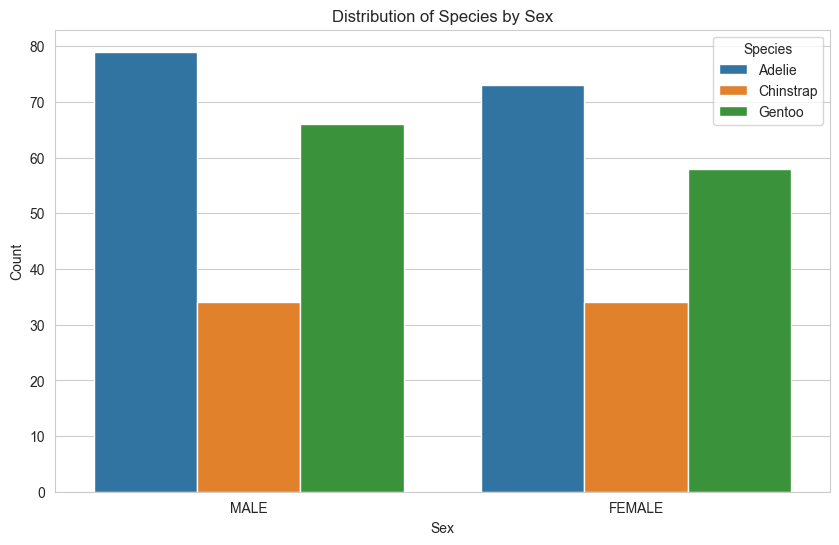

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_species_distribution_by_sex(dataframe):
    # Set style
    sns.set_style("whitegrid")

    # Create grouped bar plot
    plt.figure(figsize=(10, 6))
    sns.countplot(data=dataframe, x='sex', hue='species')
    plt.title('Distribution of Species by Sex')
    plt.xlabel('Sex')
    plt.ylabel('Count')
    plt.legend(title='Species')
    plt.show()

# Sample usage with your DataFrame
plot_species_distribution_by_sex(penguins)